# Example usage

In the following example we'll use a linear regression to forecast the number of available bikes in `bike stations <https://www.wikiwand.com/en/Bicycle-sharing_system>`_ from the city of Toulouse. Each observation looks like this:

In [6]:
from creme import datasets

X_y = datasets.Bikes()
x, y = next(iter(X_y))
x

{'moment': datetime.datetime(2016, 4, 1, 0, 0, 7),
 'station': 'metro-canal-du-midi',
 'clouds': 75,
 'description': 'light rain',
 'humidity': 81,
 'pressure': 1017.0,
 'temperature': 6.54,
 'wind': 9.3}

In [4]:
print(f'Number of bikes: {y}')

Number of bikes: 1


We will include all the available numeric features in our model. We will also use target encoding by calculating a running average of the target per station and hour. Before being fed to the linear regression, the features will be scaled using a `preprocessing.StandardScaler`. Note that each of these steps works in a streaming fashion, including the feature extraction. We'll evaluate the model by asking it to forecast 30 minutes ahead while delaying the true answers, which ensures that we're simulating a production scenario. Finally we will print the current score every 20,000 predictions.

We will now build a pipeline to learn from this stream of data. First of all we will use a `compose.Select` to select the numeric features.

In [36]:
from creme import compose

model = compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind')

Additionally, we will perform target encoding by computing a running average of the number of bikes availables per station and per hour. In order to do we first have to extract the hour from the timestamp.

In [37]:
from creme import feature_extraction
from creme import stats

def add_hour(x):
    x['hour'] = x['moment'].hour
    return x

model += (
    add_hour |
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean())
)

Let's also compute a exponentially weighted average of the number of available per station.

In [38]:
model += feature_extraction.TargetAgg(by='station', how=stats.EWMean(0.5))

We can now append to our model a linear regression. We will precede it with a `preprocessing.StandardScaler` in order to scale the data. Remember that for the moment we haven't processed any data, we're simply specifying a model.

In [39]:
from creme import linear_model
from creme import preprocessing

model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

The model can now be used to learn and make predictions.

In [40]:
model.predict_one(x)

0.0

In [42]:
for x, y in X_y.take(10):
    print(model.predict_one(x))
    model.fit_one(x, y)

0.0
0.02
0.0796
0.07846533424818158
0.27196896899252465
0.12586570728081584
0.44686768270921523
0.2765384411157542
0.7962402719642111
0.6784020335332857


Our pipeline can be visualized, either by printing it:

In [49]:
model

Pipeline (
  TransformerUnion (
    Select (
      whitelist=('clouds', 'humidity', 'pressure', 'temperature', 'wind')
    ),
    Pipeline (
      FuncTransformer (
        func="add_hour"
      ),
      TargetAgg (
        by=['station', 'hour']
        how=Mean ()
        target_name="target"
      )
    ),
    TargetAgg (
      by=['station']
      how=EWMean (
        alpha=0.5
      )
      target_name="target"
    )
  ),
  StandardScaler (
    with_mean=True
    with_std=True
  ),
  LinearRegression (
    optimizer=SGD (
      lr=InverseScaling (
        learning_rate=0.01
        power=0.25
      )
    )
    loss=Squared ()
    l2=0.
    intercept=0.744521
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

Or by drawing it.

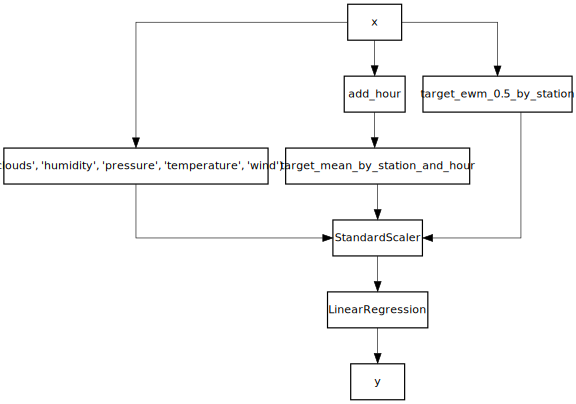

In [51]:
model.draw()

We can also use the ``debug_one`` method to inspect what is happening at each stage of our pipeline.

In [45]:
model.debug_one(x)

0. Input
--------
clouds: 75 (int)
description: light rain (str)
humidity: 81 (int)
moment: 2016-04-01 00:10:09 (datetime)
pressure: 1,017.00000 (float)
station: metro-canal-du-midi (str)
temperature: 6.54000 (float)
wind: 9.30000 (float)

1. Transformer union
--------------------
    1.0 ('clouds', 'humidity', 'pressure', 'temperature', 'wind')
    -------------------------------------------------------------
    clouds: 75 (int)
    humidity: 81 (int)
    pressure: 1,017.00000 (float)
    temperature: 6.54000 (float)
    wind: 9.30000 (float)

    1.1 add_hour | target_mean_by_station_and_hour
    ----------------------------------------------
    target_mean_by_station_and_hour: 1.00000 (float)

    1.2 target_ewm_0.5_by_station
    -----------------------------
    target_ewm_0.5_by_station: 1.00000 (float)

clouds: 75 (int)
humidity: 81 (int)
pressure: 1,017.00000 (float)
target_ewm_0.5_by_station: 1.00000 (float)
target_mean_by_station_and_hour: 1.00000 (float)
temperature: 6.540

In order to evaluate the performance of our model, we can use progressive validation. This consists in interleaving predictions with model updates, one after the other. In order to mimick a production scenario, we can delay the arrival of the ground truth so that model doesn't "cheat" by seeing it right after a prediction is made. This is all handled by the `model_selection.progressive_val_score` function.

In [56]:
import datetime as dt
from creme import metrics
from creme import model_selection

model_selection.progressive_val_score(
    X_y=X_y,
    model=model,
    metric=metrics.MAE(),
    moment='moment',
    delay=dt.timedelta(minutes=30),
    print_every=30_000
)

[30,000] MAE: 2.187625
[60,000] MAE: 2.246547
[90,000] MAE: 2.286495
[120,000] MAE: 2.263921
[150,000] MAE: 2.266359
[180,000] MAE: 2.281646


MAE: 2.285093